In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='puteshestvi.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/grecha/,NaN,Россия,Россияне автостопом добрались до Эмиратов,В Объединенные Арабские Эмираты (ОАЭ) в среду ...,Путешествия,объединить арабский эмират оаэ прибыть российс...
1,1999-10-22 12:00:00,https://lenta.ru/news/1999/10/22/kazan/,NaN,Экономика,Казанский аэропорт вышел на мировой уровень,Торжественная церемония открытия взлетно-посад...,Путешествия,торжественный церемония открытие взлетно-посад...
2,1999-12-08 12:00:00,https://lenta.ru/news/1999/12/08/leninland/,NaN,Мир,"Литовский миллионер строит ""Ленинленд""","Британская газета The Guardian поведала о том,...",Путешествия,британский газета the guardian поведать литовс...
3,1999-11-05 12:00:00,https://lenta.ru/news/1999/11/05/israel/,NaN,Россия,В Израиль будут пускать только проверенных рос...,"Группе российских туристов из 22 человек, приб...",Путешествия,российский турист 22 прибыть четвергиз санкт-п...
4,2000-01-10 12:00:00,https://lenta.ru/news/2000/01/10/queen/,NaN,Интернет и СМИ,Британская королева вкладывает деньги в Интернет,"Великобритания, которую в последнее время все ...",Путешествия,великобритания последний чаща называть наиболе...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.drop(data[data.text=='text'].index,inplace=True)

In [11]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-06 12:00:00,https://lenta.ru/news/1999/10/06/grecha/,NaN,Россия,Россияне автостопом добрались до Эмиратов,В Объединенные Арабские Эмираты (ОАЭ) в среду ...,Путешествия,объединить арабский эмират оаэ прибыть российс...,"[объединить, арабский, эмират, оаэ, прибыть, р..."
1,1999-10-22 12:00:00,https://lenta.ru/news/1999/10/22/kazan/,NaN,Экономика,Казанский аэропорт вышел на мировой уровень,Торжественная церемония открытия взлетно-посад...,Путешествия,торжественный церемония открытие взлетно-посад...,"[торжественный, церемония, открытие, взлетно-п..."
2,1999-12-08 12:00:00,https://lenta.ru/news/1999/12/08/leninland/,NaN,Мир,"Литовский миллионер строит ""Ленинленд""","Британская газета The Guardian поведала о том,...",Путешествия,британский газета the guardian поведать литовс...,"[британский, газета, the, guardian, поведать, ..."
3,1999-11-05 12:00:00,https://lenta.ru/news/1999/11/05/israel/,NaN,Россия,В Израиль будут пускать только проверенных рос...,"Группе российских туристов из 22 человек, приб...",Путешествия,российский турист 22 прибыть четвергиз санкт-п...,"[российский, турист, 22, прибыть, четвергиз, с..."
4,2000-01-10 12:00:00,https://lenta.ru/news/2000/01/10/queen/,NaN,Интернет и СМИ,Британская королева вкладывает деньги в Интернет,"Великобритания, которую в последнее время все ...",Путешествия,великобритания последний чаща называть наиболе...,"[великобритания, последний, чаща, называть, на..."


### Модель

In [12]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 1.31 s, sys: 7.52 ms, total: 1.31 s
Wall time: 1.31 s


In [13]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 1.02 s, sys: 24.2 ms, total: 1.04 s
Wall time: 1.06 s


In [14]:
num_topic=5

In [15]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.41019759355879
Coherence Score: 0.5534329555178734
CPU times: user 4min 10s, sys: 419 ms, total: 4min 11s
Wall time: 3min 38s


### Топ-топики в текстах

In [16]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 38 s, sys: 36 ms, total: 38 s
Wall time: 38.1 s


In [17]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4735,"тысяча, рубль, мир, путешественник, россия","[объединить, арабский, эмират, оаэ, прибыть, р..."
1,1,4.0,0.7198,"аэропорт, воздушный","[торжественный, церемония, открытие, взлетно-п..."
2,2,2.0,0.5025,"турист, гражданин","[британский, газета, the, guardian, поведать, ..."
3,3,2.0,0.7007,"россия, турист, российский, власть","[российский, турист, 22, прибыть, четвергиз, с..."
4,4,3.0,0.4970,"тысяча, мир","[великобритания, последний, чаща, называть, на..."
5,5,3.0,0.8555,"место, мир, рейтинг","[британский, консалтинговый, william, mercer, ..."
6,6,4.0,0.7684,"пассажир, рейс, airlines","[американский, delta, airlines, airfrance, aer..."
7,7,2.0,0.9075,,"[мингосимущество, рф, привлечение, сотрудник, ..."
8,8,4.0,0.6914,"пассажир, аэропорт, самолёт, рейс, воздушный","[часть, российский, турист, лететь, индонезия,..."
9,9,4.0,0.4870,"авиакомпания, самолёт, рейс, полёт","[великобритания, разгораться, скандал, вокруг,..."


### Статистика по топикам

In [18]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 18.7 ms, sys: 4 ms, total: 22.7 ms
Wall time: 22.3 ms


### График по времени

In [19]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/puteshestvi_update.csv.bz2',compression='bz2', index=False)

CPU times: user 22.2 s, sys: 44 ms, total: 22.3 s
Wall time: 22.3 s


In [20]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

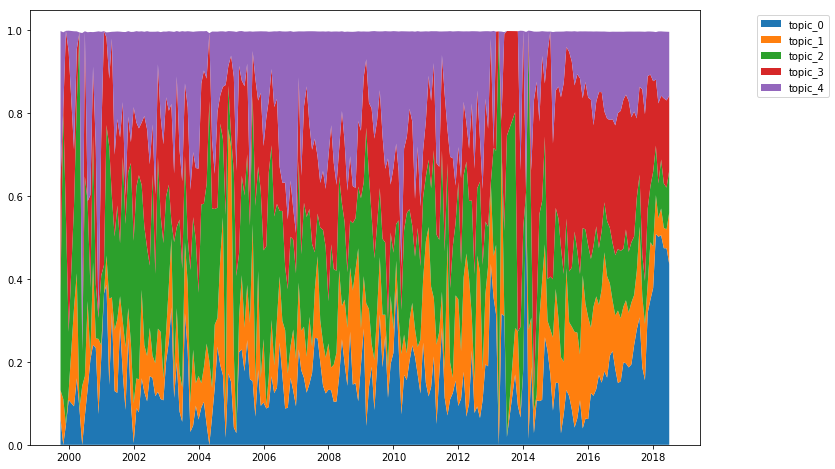

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [22]:
ldamodel1.print_topics()

[(0,
  '0.009*"турист" + 0.009*"мужчина" + 0.005*"отель" + 0.005*"сотрудник" + 0.005*"инцидент" + 0.005*"женщина" + 0.005*"произойти" + 0.004*"путешественник" + 0.003*"the" + 0.003*"из-за"'),
 (1,
  '0.021*"россия" + 0.019*"российский" + 0.016*"турист" + 0.014*"россиянин" + 0.012*"турция" + 0.009*"туроператор" + 0.007*"египет" + 0.006*"тысяча" + 0.006*"тур" + 0.005*"турецкий"'),
 (2,
  '0.009*"россия" + 0.007*"виза" + 0.006*"турист" + 0.005*"российский" + 0.005*"туризм" + 0.005*"крым" + 0.004*"власть" + 0.004*"туристический" + 0.004*"гражданин" + 0.004*"документ"'),
 (3,
  '0.011*"тысяча" + 0.009*"место" + 0.008*"рубль" + 0.008*"мир" + 0.006*"путешественник" + 0.006*"рейтинг" + 0.005*"россия" + 0.005*"путешествие" + 0.005*"отель" + 0.005*"турист"'),
 (4,
  '0.027*"пассажир" + 0.027*"авиакомпания" + 0.026*"аэропорт" + 0.025*"самолёт" + 0.025*"рейс" + 0.011*"борт" + 0.011*"полёт" + 0.011*"лайнер" + 0.009*"воздушный" + 0.008*"airlines"')]

### Топ слова.

In [23]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [24]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [25]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

турист - 7011 times.
россия - 6248 times.
российский - 5348 times.
тысяча - 5187 times.
рейс - 4820 times.
аэропорт - 4583 times.
авиакомпания - 4312 times.
пассажир - 3754 times.
самолёт - 3705 times.
путешественник - 3626 times.
место - 3353 times.
москва - 3085 times.
россиянин - 3025 times.
рубль - 3015 times.
отель - 2845 times.
из-за - 2413 times.
туристический - 2347 times.
день - 2300 times.
полёт - 2183 times.
турция - 2024 times.
миллион - 1948 times.
отдых - 1920 times.
мир - 1916 times.
направление - 1885 times.
лайнер - 1878 times.
билет - 1770 times.
курорт - 1763 times.
доллар - 1739 times.
2016 - 1720 times.
путешествие - 1717 times.
около - 1688 times.
гостиница - 1670 times.
туроператор - 1658 times.
борт - 1630 times.
воздушный - 1619 times.
туризм - 1613 times.
большой - 1605 times.
сайт - 1586 times.
произойти - 1563 times.
перевозчик - 1562 times.
виза - 1533 times.
2015 - 1522 times.
поездка - 1458 times.
составить - 1452 times.
ру - 1427 times.
стоимость - 1417 